# Análise de Sentimentos IMDB Reviews

## Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk as nltk

## Importando Dados

In [2]:
dados = pd.read_csv('C:\\Users\\User\\Downloads\\IMDB Dataset.csv')

In [3]:
dados.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# Verificando se as váriaveis categóricas estão balanceadas

dados['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

# Nuvem Palavras

## Vizualizando as palavras que mais aparecem em reviews negativas e positivas

In [5]:
from wordcloud import WordCloud

# Definindo nuvens palavras

def nuvem_palavras_neg(texto, coluna_texto):
    texto_negativo = texto.query("sentiment == 'negative'") # <- buscando as reviews
    todas_palavras = ' '.join([texto for texto in texto_negativo[coluna_texto]]) # <- Juntando toda a lista "texto" com o metodo .join o ' ' na frente é separador usado

    nuvem_palavras = WordCloud(width= 800, height= 500,
                              max_font_size = 110,colormap='YlOrRd',
                              collocations = False).generate(todas_palavras)
    plt.figure(figsize=(10,7))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def nuvem_palavras_pos(texto, coluna_texto):
    texto_negativo = texto.query("sentiment == 'positive'") # <- buscando as reviews positivas
    todas_palavras = ' '.join([texto for texto in texto_negativo[coluna_texto]])

    nuvem_palavras = WordCloud(width= 800, height= 500,
                              max_font_size = 110, colormap='BuGn',
                              collocations = False).generate(todas_palavras)
    plt.figure(figsize=(10,7))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis("off")
    plt.show()

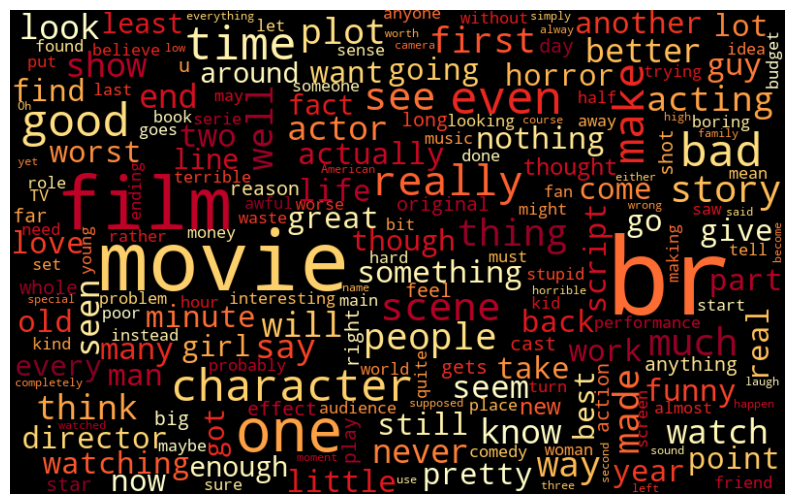

In [6]:
nuvem_palavras_neg(dados,"review")

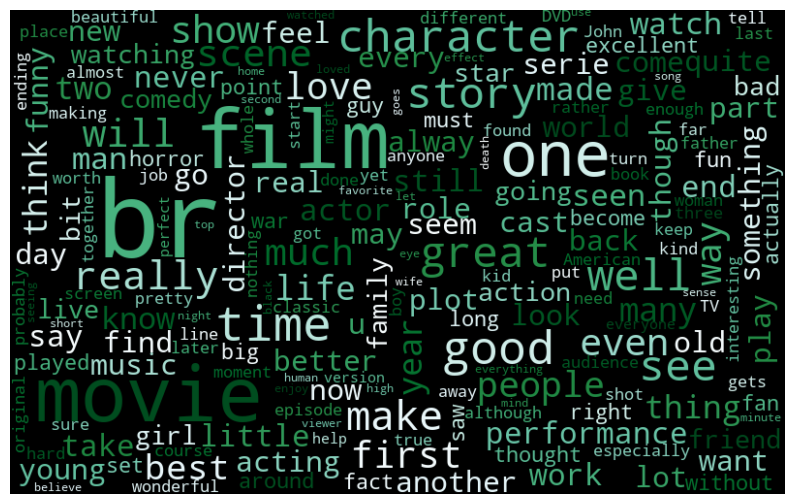

In [7]:
nuvem_palavras_pos(dados,"review")

## SentimentIntensityAnalyzer

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [9]:
sia = SentimentIntensityAnalyzer()

In [10]:
def apply_sia(texto):
    return sia.polarity_scores(texto)

In [11]:
dados_polarity = pd.DataFrame(dados['review'].apply(apply_sia))
lista_dicts = dados_polarity['review'].tolist()

In [12]:
vaders = pd.DataFrame(lista_dicts)

In [13]:
vaders.head()

,neg,neu,pos,compound
0,0.203,0.748,0.048,-0.9951
1,0.053,0.776,0.172,0.9641
2,0.094,0.714,0.192,0.9605
3,0.138,0.797,0.065,-0.9213
4,0.052,0.801,0.147,0.9744


In [14]:
sia.polarity_scores(dados['review'][1])

{'neg': 0.053, 'neu': 0.776, 'pos': 0.172, 'compound': 0.9641}

In [15]:
resultados = pd.concat([dados, vaders], axis=1)
resultados.query("sentiment == 1")

,review,sentiment,neg,neu,pos,compound


In [16]:
# Da para calcular através da coluna sentiment e compound o grau de acerto

# Pré Processamento dos dados

In [17]:
# Binarizando a coluna Sentiment
dados['sentiment'] = dados['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [18]:
# Removendo caracteres especiais
import re

def remover_special_characters(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

dados['review'] = dados['review'].apply(remover_special_characters)

# Removendo HTML
def remover_html(texto):
    
    pattern = re.compile(r'<[^>]+>')

    texto_sem_html = re.sub(pattern, '', texto)
    
    return texto_sem_html

dados['review'] = dados['review'].apply(remover_html)

# Removendo Tags de Spoiler por exemplo que estão com []
def removendo_entre_colchetes(text):
    return re.sub('\[[^]]*\]', '', text)

dados['review'] = dados['review'].apply(removendo_entre_colchetes)


In [19]:
# Tokenizando o texto
from nltk.tokenize import word_tokenize

def tokenizar_texto(texto):
    return word_tokenize(texto)

dados['tokens'] = dados['review'].apply(tokenizar_texto)


In [20]:
# Removendo Stop Words e colocando tudo minusculo
from nltk.corpus import stopwords

stopwords = stopwords.words('english')

dados['tokens'] = dados['tokens'].apply(lambda tokens: [token.lower() for token in tokens if token.lower() not in stopwords])

print(dados['tokens'])

0        [one, reviewers, mentioned, watching, 1, oz, e...
1        [wonderful, little, production, br, br, filmin...
2        [thought, wonderful, way, spend, time, hot, su...
3        [basically, theres, family, little, boy, jake,...
4        [petter, matteis, love, time, money, visually,...
                               ...                        
49995    [thought, movie, right, good, job, wasnt, crea...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [catholic, taught, parochial, elementary, scho...
49998    [im, going, disagree, previous, comment, side,...
49999    [one, expects, star, trek, movies, high, art, ...
Name: tokens, Length: 50000, dtype: object


In [21]:
# Lemmanizando
from nltk.stem import WordNetLemmatizer
 
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

dados['tokens'] = dados['tokens'].apply(lambda tokens: lemmatize_tokens(tokens))
print(dados['tokens'])

0        [one, reviewer, mentioned, watching, 1, oz, ep...
1        [wonderful, little, production, br, br, filmin...
2        [thought, wonderful, way, spend, time, hot, su...
3        [basically, there, family, little, boy, jake, ...
4        [petter, matteis, love, time, money, visually,...
                               ...                        
49995    [thought, movie, right, good, job, wasnt, crea...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [catholic, taught, parochial, elementary, scho...
49998    [im, going, disagree, previous, comment, side,...
49999    [one, expects, star, trek, movie, high, art, f...
Name: tokens, Length: 50000, dtype: object


In [22]:
# Splitando os dados
from sklearn.model_selection import train_test_split

x_treino, x_teste, y_treino, y_teste = train_test_split(dados['tokens'], dados['sentiment'], test_size=0.35, random_state=16)


In [23]:
# Transformando as listas de tokens em uma lista unica
x_treino_strings = [' '.join(words) for words in x_treino]
x_test_strings = [' '.join(words) for words in x_teste]

# Bag of Words

In [24]:
# Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=15, ngram_range=(1,3), lowercase=False)

In [25]:
# Bag of Words
CountVectorizer_Train = vectorizer.fit_transform(x_treino_strings)
CountVectorizer_Test = vectorizer.transform(x_test_strings)

In [26]:
print(CountVectorizer_Train.shape)
print(CountVectorizer_Test.shape)

(32500, 37137)
(17500, 37137)


# Term of Frequency

In [27]:
# Term of Frequency
from sklearn.feature_extraction.text import TfidfVectorizer
tfvectorizer=TfidfVectorizer(min_df=15, use_idf=True,ngram_range=(1,3))
tfvectorizer_Train = tfvectorizer.fit_transform(x_treino_strings)
tfvectorizer_Test = tfvectorizer.transform(x_test_strings)

In [28]:
print(tfvectorizer_Train.shape)
print(tfvectorizer_Test.shape)

(32500, 37137)
(17500, 37137)


## Models & Score Import

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


# Model Selection

In [30]:
modelos = []

modelos.append(('Logistic Regression',LogisticRegression()))
modelos.append(('Decision Tree Classifier',DecisionTreeClassifier()))
modelos.append(('Random Forest Classifier',RandomForestClassifier()))

In [31]:
# Bag of Words
pre_pontuacoes_bw = {}
for nome , modelo in modelos:
    np.random.seed(16)
    modelo.fit(CountVectorizer_Train,y_treino)
    predict = modelo.predict(CountVectorizer_Test)
    acurácia = accuracy_score(y_teste, predict)
    pre_pontuacoes_bw[nome] = acurácia 
    print(f'Para o {nome} a acurácia foi de: {acurácia}')


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Para o Logistic Regression a acurácia foi de: 0.8897142857142857
Para o Decision Tree Classifier a acurácia foi de: 0.7241142857142857
Para o Random Forest Classifier a acurácia foi de: 0.8592


In [33]:
# Term of Frequency
pre_pontuacoes_tf = {}
for nome , modelo in modelos:
    np.random.seed(16)
    modelo.fit(tfvectorizer_Train,y_treino)
    predict = modelo.predict(tfvectorizer_Test)
    acurácia = accuracy_score(y_teste, predict)
    pre_pontuacoes_tf[nome] = acurácia 
    print(f'Para o {nome} a acurácia foi de: {acurácia}')


Para o Logistic Regression a acurácia foi de: 0.8958857142857143
Para o Decision Tree Classifier a acurácia foi de: 0.7259428571428571
Para o Random Forest Classifier a acurácia foi de: 0.8525714285714285


In [34]:
# Comparando Bag of Words e Term of Frequency
df_bw = pd.DataFrame.from_dict(pre_pontuacoes_bw, orient='index', columns=['Acurácia_BW'])
df_tf = pd.DataFrame.from_dict(pre_pontuacoes_tf, orient='index', columns=['Acurácia_TF'])
df_acurácia = pd.concat([df_tf, df_bw], axis=1)
df_acurácia

,Acurácia_TF,Acurácia_BW
Logistic Regression,0.895886,0.889714
Decision Tree Classifier,0.725943,0.724114
Random Forest Classifier,0.852571,0.859200


Podemos ver que ambos nesse caso são bem próximos para os próximos passos vou estar seguindo a o metodo de Term of Frequency para realizar o Tunning dos modelos

# Model Tuning

In [35]:
# Hyper Parâmetros que vamos estar tentando melhorar
modelos = [
    ('Logistic Regression', LogisticRegression(), {
        'C': [1,5,10,15],
        'penalty': ['l2'],
        'max_iter': [200, 300, 700],
    }),
    ('Decision Tree Classifier', DecisionTreeClassifier(), {
        'max_depth': [10, 20, 35],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    }),
    ('Random Forest', RandomForestClassifier(), {
        'n_estimators': [50, 150, 500],
        'criterion': ['gini', 'entropy'],
        'max_depth': [35, 10, 20],
        'max_features': ['sqrt', 'log2']
    })
] 

Em um primeiro momento eu iria utilizar o RandomizedSearchCV por ter um melhor desempenho pois em meus testes o GridSearch estava demorando muito, posteriormente descobri que o problema era o algoritmo que desde o inicio apresentava pior perfomace o KNN que estava fazendo demorar, resolvi manter o RandomizedSearch por questões de comparação.

### RandomizedSearchCV

In [36]:
from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV


resultados_tuning_Random = {}
resultados_best_param_Random = {}

for nome, modelo, parametros in tqdm(modelos, desc='Progresso', unit='modelo'):
    
    np.random.seed(16)
    
    random_search = RandomizedSearchCV(estimator=modelo, param_distributions=parametros, scoring='accuracy', cv=5, n_iter=10, n_jobs=-1)
    random_search.fit(tfvectorizer_Train, y_treino)
    
    melhor_modelo = random_search.best_estimator_
    melhor_score = random_search.best_score_
    
    resultados_tuning_Random[nome] = melhor_score 
    resultados_best_param_Random[nome] = melhor_modelo.get_params()

    print(f"Melhor modelo para {nome}: {melhor_modelo}")
    print(f"Acurácia: {melhor_score:.2f}")

Progresso:  33%|███████████████████████                                              | 1/3 [00:31<01:03, 31.59s/modelo]

Melhor modelo para Logistic Regression: LogisticRegression(C=5, max_iter=300)
Acurácia: 0.90


Progresso:  67%|██████████████████████████████████████████████                       | 2/3 [02:48<01:33, 93.80s/modelo]

Melhor modelo para Decision Tree Classifier: DecisionTreeClassifier(max_depth=20)
Acurácia: 0.74


Progresso: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [04:12<00:00, 84.07s/modelo]

Melhor modelo para Random Forest: RandomForestClassifier(criterion='entropy', max_depth=35, max_features='log2',
                       n_estimators=500)
Acurácia: 0.86


### GridSearchCV


In [37]:
from sklearn.model_selection import GridSearchCV

resultados_tuning_Grid = {}
resultados_best_param_Grid = {}

for nome, modelo, parametros in tqdm(modelos, desc='Progresso'):
    
    np.random.seed(16)
    
    grid_search = GridSearchCV(estimator=modelo, param_grid=parametros, scoring='accuracy', cv=5, n_jobs=-1)
    grid_search.fit(tfvectorizer_Train, y_treino)
    
    melhor_modelo = grid_search.best_estimator_
    melhor_score = grid_search.best_score_
    
    resultados_tuning_Grid[nome] = melhor_score 
    resultados_best_param_Grid[nome] = melhor_modelo.get_params()
    
    print(f"Melhor modelo para {nome}: {melhor_modelo}")
    print(f"Acurácia: {melhor_score:.2f}")
    


Progresso:  33%|████████████████████████▎                                                | 1/3 [00:36<01:13, 36.78s/it]

Melhor modelo para Logistic Regression: LogisticRegression(C=5, max_iter=200)
Acurácia: 0.90


Progresso:  67%|████████████████████████████████████████████████                        | 2/3 [04:00<02:14, 134.80s/it]

Melhor modelo para Decision Tree Classifier: DecisionTreeClassifier(max_depth=20, min_samples_split=5)
Acurácia: 0.74


Progresso: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [10:22<00:00, 207.46s/it]

Melhor modelo para Random Forest: RandomForestClassifier(criterion='entropy', max_depth=35, max_features='log2',
                       n_estimators=500)
Acurácia: 0.86


## Lista de Modelos e Selecionando Melhores Parâmetros

In [38]:
modelos = []

modelos.append(('Logistic Regression',LogisticRegression()))
modelos.append(('Decision Tree Classifier',DecisionTreeClassifier()))
modelos.append(('Random Forest',RandomForestClassifier()))

for nome, params in resultados_best_param_Random.items(): # <- alterando aqui o resultados_best_param escolhemos entre Random e Grid
    for idx, (modelo_nome, modelo) in enumerate(modelos):
        if modelo_nome == nome:
            modelos[idx] = (modelo_nome, modelo.__class__(**params))

# Bag of Words

## Pontuacoes para os modelos em Bag of Words

In [39]:
pontuacoes_bw = {}
for nome , modelo in modelos:
    np.random.seed(16)
    modelo.fit(CountVectorizer_Train,y_treino)
    predict = modelo.predict(CountVectorizer_Test)
    acurácia = accuracy_score(y_teste, predict)
    pontuacoes_bw[nome] = acurácia 
    print(f'Para o {nome} a acurácia foi de: {acurácia}')


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Para o Logistic Regression a acurácia foi de: 0.8863428571428571
Para o Decision Tree Classifier a acurácia foi de: 0.7429714285714286
Para o Random Forest a acurácia foi de: 0.8642857142857143


# Term of Frequency

## Pontuacoes para os modelos em Term of Frequency

In [41]:
pontuacoes_tf = {}
for nome , modelo in modelos:
    np.random.seed(16)
    modelo.fit(tfvectorizer_Train,y_treino)
    predict = modelo.predict(tfvectorizer_Test)
    acurácia = accuracy_score(y_teste, predict)
    pontuacoes_tf[nome] = acurácia 
    print(f'Para o {nome} a acurácia foi de: {acurácia}')


Para o Logistic Regression a acurácia foi de: 0.9024571428571428
Para o Decision Tree Classifier a acurácia foi de: 0.7430857142857142
Para o Random Forest a acurácia foi de: 0.8598857142857143


In [42]:
print(f'O resultado do RandomizedSearchCV foi: {resultados_tuning_Random}')
print('-'*126)
print(f'O resultado do Grid Search CV: {resultados_tuning_Grid}')
print('-'*126)
print(f'O resultado do Term of Frequency: {pontuacoes_tf}')
print('-'*126)
print(f'O resultado do Bag of words: {pontuacoes_bw}')

O resultado do RandomizedSearchCV foi: {'Logistic Regression': 0.9001538461538463, 'Decision Tree Classifier': 0.7381538461538462, 'Random Forest': 0.8614461538461539}
------------------------------------------------------------------------------------------------------------------------------
O resultado do Grid Search CV: {'Logistic Regression': 0.9001538461538463, 'Decision Tree Classifier': 0.740276923076923, 'Random Forest': 0.859476923076923}
------------------------------------------------------------------------------------------------------------------------------
O resultado do Term of Frequency: {'Logistic Regression': 0.9024571428571428, 'Decision Tree Classifier': 0.7430857142857142, 'Random Forest': 0.8598857142857143}
------------------------------------------------------------------------------------------------------------------------------
O resultado do Bag of words: {'Logistic Regression': 0.8863428571428571, 'Decision Tree Classifier': 0.7429714285714286, 'Random F

In [43]:

acuracia_tuning_Random = pd.DataFrame.from_dict(resultados_tuning_Random, orient='index', columns=['Acurácia_Random'])
acuracia_tuning_Grid = pd.DataFrame.from_dict(resultados_tuning_Grid, orient='index', columns=['Acurácia_Grid'])
acuracia_tuning_TF = pd.DataFrame.from_dict(pontuacoes_tf, orient='index', columns=['Acurácia_TF'])
acuracia_tuning_BW = pd.DataFrame.from_dict(pontuacoes_bw, orient='index', columns=['Acurácia_BW'])

df_acurácia_final = pd.concat([acuracia_tuning_Random,acuracia_tuning_Grid,acuracia_tuning_TF,acuracia_tuning_BW], axis=1)

df_acurácia_final


,Acurácia_Random,Acurácia_Grid,Acurácia_TF,Acurácia_BW
Logistic Regression,0.900154,0.900154,0.902457,0.886343
Decision Tree Classifier,0.738154,0.740277,0.743086,0.742971
Random Forest,0.861446,0.859477,0.859886,0.864286
